In [41]:
# set this to the graph type to generate
# can be one of:
# 1. shared_hca
# 2. softroce
# 3. sriov
MODE = "sriov"

<IPython.core.display.Javascript object>

In [42]:
%load_ext nb_black

import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import pandas as pd

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [43]:
IB_METHODS = ["read", "write", "send"]
SERVER_TYPES = ["server", "client"]

if MODE == "softroce":
    SUFFIXES = ["host", "rxe"]
    DATA_DIR = "softroce"
    TITLE_DEV_NAME = "SoftRoCE"
    LEGEND_DEV_NAME = "rxe"
elif MODE == "shared_hca":
    SUFFIXES = ["host", "shared"]
    DATA_DIR = "shared_hca"
    TITLE_DEV_NAME = "Shared HCA"
    LEGEND_DEV_NAME = "shared"
elif MODE == "sriov":
    SUFFIXES = ["host", "sriov"]
    DATA_DIR = "sriov"
    TITLE_DEV_NAME = "SRIOV"
    LEGEND_DEV_NAME = "SRIOV"

<IPython.core.display.Javascript object>

In [44]:
def get_data_start_stop_idx(rows):
    start_idx = None
    end_idx = None

    for idx, r in enumerate(rows):
        if r.startswith("-----"):
            start_idx = end_idx
            end_idx = idx

    return start_idx + 1, end_idx

<IPython.core.display.Javascript object>

In [45]:
bw_dfs = {}

for method in IB_METHODS:
    _dfs = []
    for suffix in SUFFIXES:
        with open(f"raw/{DATA_DIR}_basic_tests/ib_{method}_bw_{suffix}.txt") as f:
            raw_data = f.read().strip().split("\n")

        start, stop = get_data_start_stop_idx(raw_data)
        raw_data = [
            r.split() if idx != 0 else [x.strip() for x in r.split("  ") if x]
            for idx, r in enumerate(raw_data[start:stop])
        ]
        df = (
            pd.DataFrame(columns=raw_data[0], data=raw_data[1:])
            .drop(["#iterations"], axis=1)
            .astype(
                {
                    "#bytes": "int64",
                    "BW peak[MB/sec]": "float64",
                    "BW average[MB/sec]": "float64",
                    "MsgRate[Mpps]": "float64",
                }
            )
        )
        df["type"] = suffix
        df = df.set_index(["#bytes", "type"])
        _dfs.append(df)

    bw_dfs[method] = pd.concat(_dfs)
    bw_dfs[method]

bw_dfs[IB_METHODS[0]].head()

,,BW peak[MB/sec],BW average[MB/sec],MsgRate[Mpps]
#bytes,type,,,
2,host,5.13,5.11,2.681066
4,host,10.45,10.44,2.736999
8,host,20.93,20.91,2.741213
16,host,41.81,41.79,2.738982
32,host,83.72,83.69,2.742506


<IPython.core.display.Javascript object>

In [46]:
lat_dfs = {}

for method in IB_METHODS:
    _dfs = []
    for suffix in SUFFIXES:
        with open(f"raw/{DATA_DIR}_basic_tests/ib_{method}_lat_{suffix}.txt") as f:
            raw_data = f.read().strip().split("\n")

        start, stop = get_data_start_stop_idx(raw_data)
        raw_data = [
            r.split() if idx != 0 else [x.strip() for x in r.split("  ") if x]
            for idx, r in enumerate(raw_data[start:stop])
        ]
        raw_data[0][0], rst = raw_data[0][0].split(" ")
        raw_data[0].insert(1, rst)

        df = (
            pd.DataFrame(columns=raw_data[0], data=raw_data[1:])
            .drop(["#iterations"], axis=1)
            .astype(
                {
                    "#bytes": "int64",
                    "t_min[usec]": "float64",
                    "t_max[usec]": "float64",
                    "t_typical[usec]": "float64",
                    "t_avg[usec]": "float64",
                    "t_stdev[usec]": "float64",
                    "99% percentile[usec]": "float64",
                    "99.9% percentile[usec]": "float64",
                }
            )
        )
        df["type"] = suffix
        df = df.set_index(["#bytes", "type"])
        _dfs.append(df)

    lat_dfs[method] = pd.concat(_dfs)
    lat_dfs[method]

lat_dfs[IB_METHODS[0]].head()

,,t_min[usec],t_max[usec],t_typical[usec],t_avg[usec],t_stdev[usec],99% percentile[usec],99.9% percentile[usec]
#bytes,type,,,,,,,
2,host,3.36,5.42,3.43,3.43,0.01,3.49,5.42
4,host,3.33,3.66,3.43,3.43,0.01,3.49,3.66
8,host,3.41,3.69,3.43,3.43,0.01,3.49,3.69
16,host,3.41,3.70,3.43,3.43,0.01,3.49,3.70
32,host,3.41,3.74,3.44,3.44,0.02,3.49,3.74


<IPython.core.display.Javascript object>

In [47]:
cpu_dfs = {}

for method in IB_METHODS:
    _dfs = []
    for suffix in SUFFIXES:
        for server_type in SERVER_TYPES:
            with open(
                f"raw/{DATA_DIR}_cpu_tests/{method}_cpu_{server_type}_{suffix}.txt"
            ) as f:
                raw_data = f.read().strip().split("\n")

            raw_data = [r.split("\t") for r in raw_data]
            df = pd.DataFrame(columns=raw_data[0], data=raw_data[1:]).astype(
                {"msg bytes": "int64", "cpu util pct": "float64"}
            )
            df["type"] = suffix
            df["server_type"] = server_type
            df = df.set_index(["msg bytes", "type", "server_type"])
            _dfs.append(df)

    cpu_dfs[method] = pd.concat(_dfs)
    cpu_dfs[method]

cpu_dfs[IB_METHODS[0]].head()

,,,cpu util pct
msg bytes,type,server_type,
2,host,server,0.64
4,host,server,0.64
8,host,server,0.64
16,host,server,0.64
32,host,server,0.64


<IPython.core.display.Javascript object>

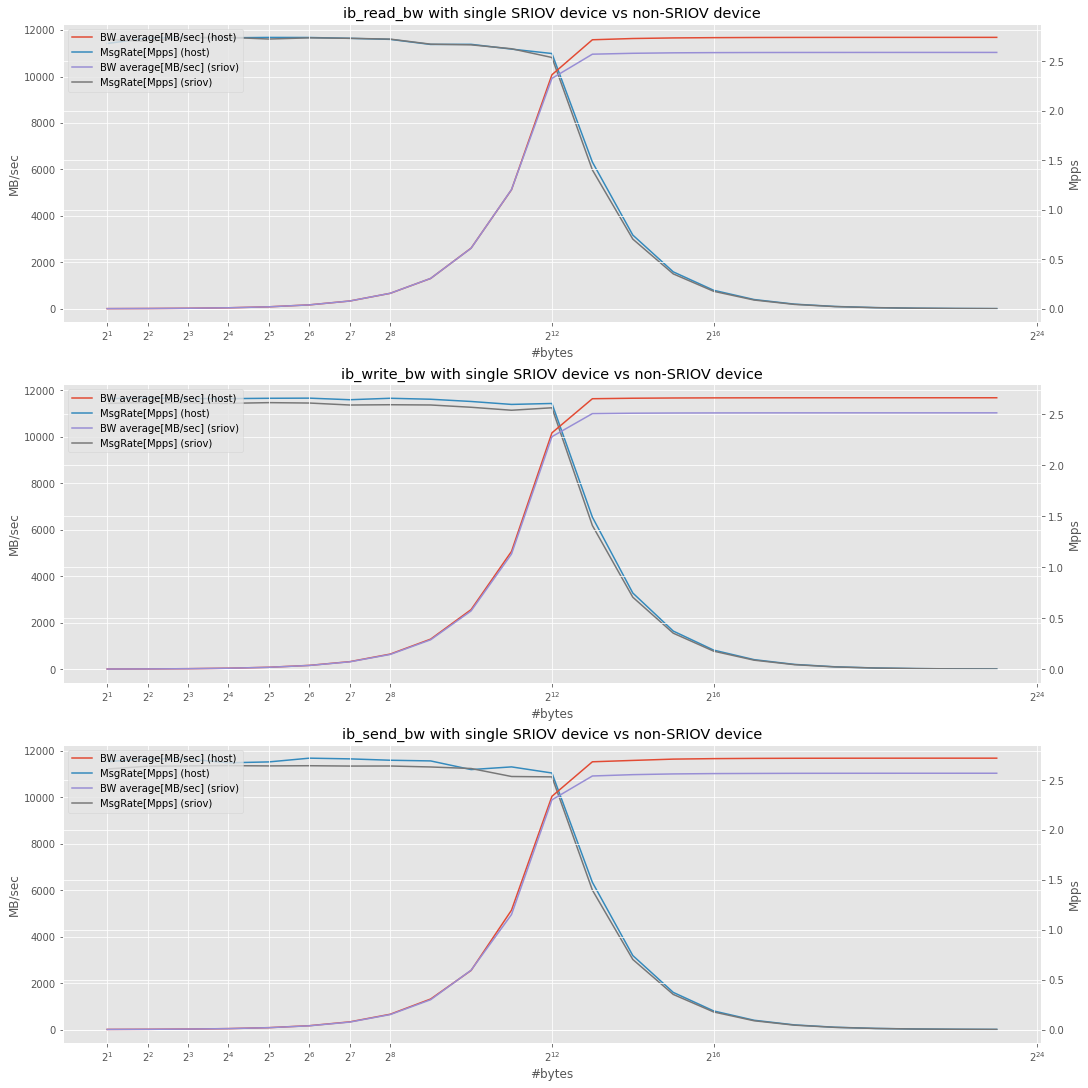

<IPython.core.display.Javascript object>

In [48]:
fig, axs = plt.subplots(len(bw_dfs), 1, layout="constrained")
idx = 0

for method, df in bw_dfs.items():
    color_idx = 0
    ax = axs[idx]

    twin1 = ax.twinx()

    ax.set_zorder(twin1.get_zorder() + 1)
    ax.patch.set_visible(False)
    twin1.patch.set_visible(True)

    handles = []
    for suffix in SUFFIXES:
        (p1,) = ax.plot(
            df.xs(suffix, level=1).index,
            df.xs(suffix, level=1)["BW average[MB/sec]"],
            color=colors[color_idx % len(colors)],
            label=f"BW average[MB/sec] ({suffix})",
        )
        (p2,) = twin1.plot(
            df.xs(suffix, level=1).index,
            df.xs(suffix, level=1)["MsgRate[Mpps]"],
            color=colors[(color_idx + 1) % len(colors)],
            label=f"MsgRate[Mpps] ({suffix})",
        )
        color_idx += 2
        handles += [p1, p2]

    ax.set_xscale("log", base=2)
    ax.set_xticks([2**x for x in list(range(1, 9)) + [12, 16, 24]])
    # ax.set_ylim(0, 12000)
    # twin1.set_ylim(0, 6000)

    ax.set_xlabel("#bytes")
    ax.set_ylabel("MB/sec")
    twin1.set_ylabel("Mpps")

    ax.legend(handles=handles)
    ax.set_title(
        f"ib_{method}_bw with single {TITLE_DEV_NAME} device vs non-{TITLE_DEV_NAME} device"
    )

    idx += 1

plt.savefig(f"{DATA_DIR}_basic_bw.png")
plt.show()

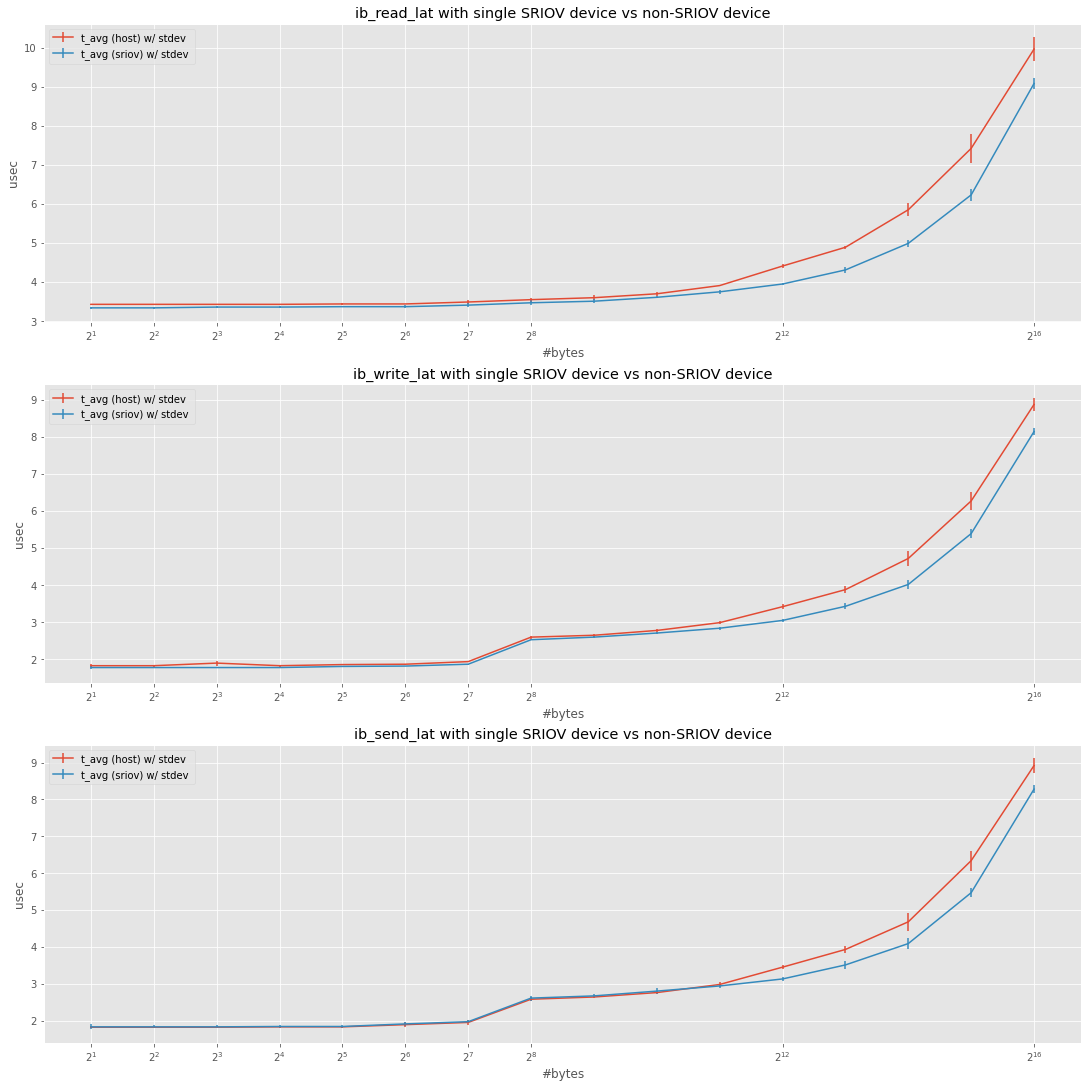

<IPython.core.display.Javascript object>

In [49]:
fig, axs = plt.subplots(len(lat_dfs), 1, layout="constrained")
idx = 0

for method, df in lat_dfs.items():
    color_idx = 0
    ax = axs[idx]
    df = df.loc[df.index.get_level_values("#bytes") <= 2**16]

    handles = []
    for suffix in SUFFIXES:
        p1 = ax.errorbar(
            df.xs(suffix, level=1).index,
            df.xs(suffix, level=1)["t_avg[usec]"],
            yerr=df.xs(suffix, level=1)["t_stdev[usec]"],
            color=colors[color_idx % len(colors)],
            label=f"t_avg ({suffix}) w/ stdev ",
        )
        color_idx += 1
        handles += [p1]

    ax.set_xscale("log", base=2)
    ax.set_xticks([2**x for x in list(range(1, 9)) + [12, 16]])
    ax.set_xlabel("#bytes")

    ax.set_ylabel("usec")

    ax.legend(handles=handles)
    ax.set_title(
        f"ib_{method}_lat with single {TITLE_DEV_NAME} device vs non-{TITLE_DEV_NAME} device"
    )

    idx += 1

plt.savefig(f"{DATA_DIR}_basic_lat.png")
plt.show()

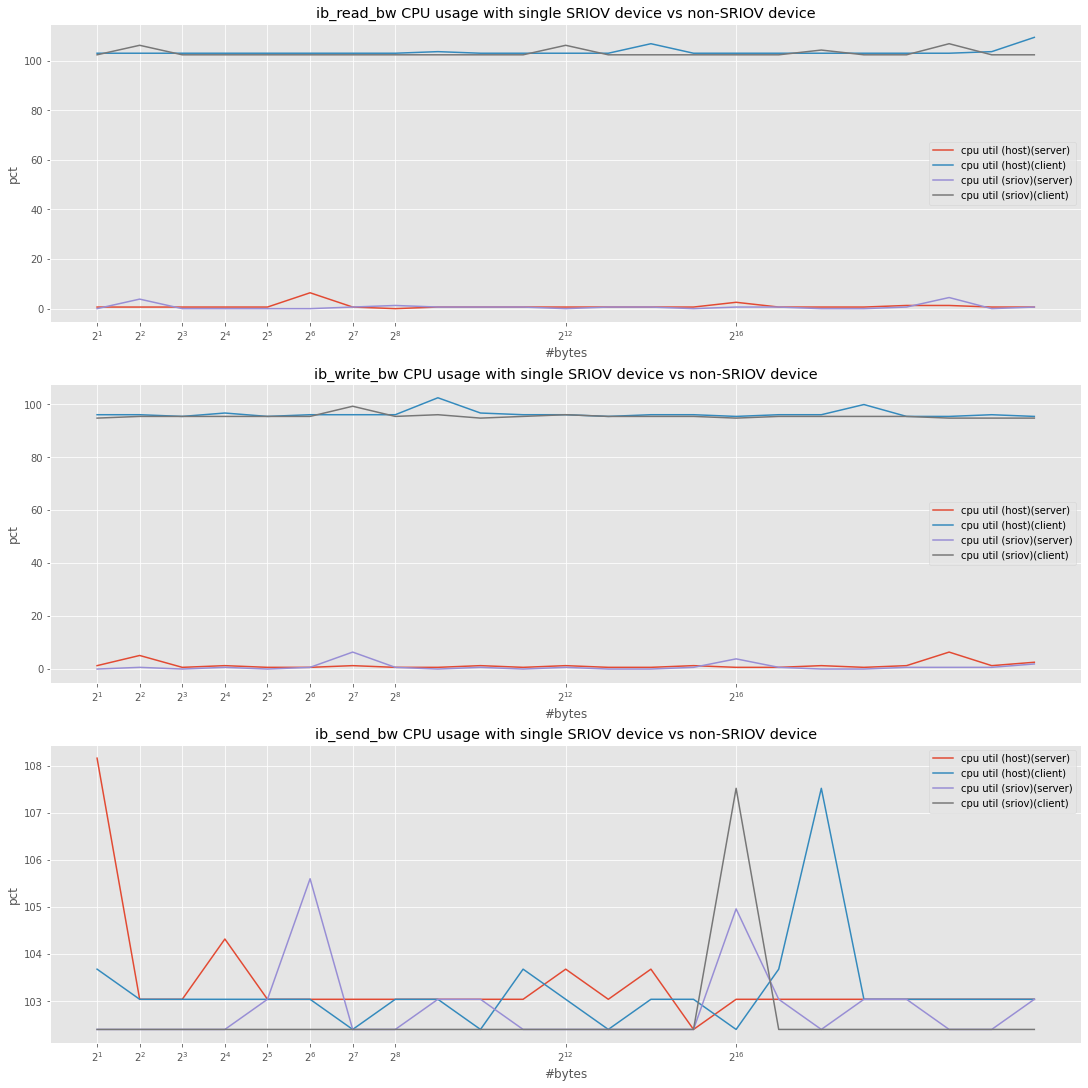

<IPython.core.display.Javascript object>

In [50]:
fig, axs = plt.subplots(len(cpu_dfs), 1, layout="constrained")
idx = 0

for method, df in cpu_dfs.items():
    color_idx = 0
    ax = axs[idx]

    handles = []
    for suffix in SUFFIXES:
        for server_type in SERVER_TYPES:
            (p1,) = ax.plot(
                df.xs(suffix, level=1).xs(server_type, level=1).index,
                df.xs(suffix, level=1).xs(server_type, level=1)["cpu util pct"],
                color=colors[color_idx % len(colors)],
                label=f"cpu util ({suffix})({server_type})",
            )
            color_idx += 1
            handles += [p1]

    ax.set_xscale("log", base=2)
    ax.set_xticks([2**x for x in list(range(1, 9)) + [12, 16]])
    ax.set_xlabel("#bytes")

    ax.set_ylabel("pct")

    ax.legend(handles=handles)
    ax.set_title(
        f"ib_{method}_bw CPU usage with single {TITLE_DEV_NAME} device vs non-{TITLE_DEV_NAME} device"
    )

    idx += 1

plt.savefig(f"{DATA_DIR}_cpu.png")
plt.show()